In [3]:
#!pip install tensorflow[and-cuda]

In [4]:
#!pip install opencv-python

In [5]:
#!pip install pillow


In [73]:
import os
import shutil
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image


In [48]:
import os
current_directory = os.getcwd()
print(current_directory)
dir_base = os.path.join(current_directory,'Dataset')
print(dir_base)
fire_base = os.path.join(dir_base,'fire_images')
print(fire_base)
non_fire_base = os.path.join(dir_base,'non_fire_images')
print(non_fire_base)
# Define new output base directory
output_base_ = os.path.join(current_directory, 'Output')
print("Output Directory:", output_base_)

/home/ladans/Computer Vision/Final Project
/home/ladans/Computer Vision/Final Project/Dataset
/home/ladans/Computer Vision/Final Project/Dataset/fire_images
/home/ladans/Computer Vision/Final Project/Dataset/non_fire_images
Output Directory: /home/ladans/Computer Vision/Final Project/Output


In [49]:
print(os.path.join(output_base_, "train"))

/home/ladans/Computer Vision/Final Project/Output/train


In [50]:
import os
import shutil
import random
from sklearn.model_selection import train_test_split

# List all images, ensuring only files are included (excluding directories like .ipynb_checkpoints)
fire_images = [os.path.join(fire_base, img) for img in os.listdir(fire_base) 
               if os.path.isfile(os.path.join(fire_base, img)) and not img.startswith('.')]
nonfire_images = [os.path.join(non_fire_base, img) for img in os.listdir(non_fire_base) 
                  if os.path.isfile(os.path.join(non_fire_base, img)) and not img.startswith('.')]

# Assign labels
fire_labels = [1] * len(fire_images)
nonfire_labels = [0] * len(nonfire_images)

# Combine datasets
all_images = fire_images + nonfire_images
all_labels = fire_labels + nonfire_labels

# Split dataset into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(all_images, all_labels, test_size=0.3, stratify=all_labels, random_state=20)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=20)

# Define output directories for dataset splits
output_dirs = {
    "train": os.path.join(output_base_, "train"),
    "val": os.path.join(output_base_, "val"),
    "test": os.path.join(output_base_, "test")
}

# Create directories for each split (fire and nonfire folders inside)
for split in output_dirs:
    os.makedirs(os.path.join(output_dirs[split], "fire"), exist_ok=True)
    os.makedirs(os.path.join(output_dirs[split], "nonfire"), exist_ok=True)

# Function to copy images to their respective directories
def copy_images(image_paths, labels, split):
    for img_path, label in zip(image_paths, labels):
        if not os.path.isfile(img_path):  # Ensure it's a file, not a directory
            print(f"Skipping non-file: {img_path}")
            continue
        category = "fire" if label == 1 else "nonfire"
        dest_path = os.path.join(output_dirs[split], category, os.path.basename(img_path))
        shutil.copy(img_path, dest_path)

# Copy images into their respective folders
copy_images(X_train, y_train, "train")
copy_images(X_val, y_val, "val")
copy_images(X_test, y_test, "test")

print("Dataset successfully split and saved.")


Dataset successfully split and saved.


In [75]:
img_size=(320,320)
bth_size=32

# Augmenting Images for training set

trdatagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    validation_split=0.1
)

# Only Rescaling or Normalizing the pixel values for testing Set
tedatagen = ImageDataGenerator(rescale=1.0/255)

In [76]:
# Reading the training data from directory

traingen= trdatagen.flow_from_directory(
    os.path.join(output_base_, "train"),
    target_size=img_size,
    batch_size=bth_size,
    color_mode='rgb',  
    class_mode='categorical',
    shuffle=True)

# Reading the testing data from Directory

testgen = tedatagen.flow_from_directory(
    os.path.join(output_base_, "test"),
    target_size=img_size,
    batch_size=bth_size,
    color_mode='rgb', 
    class_mode='categorical',
    shuffle=False
)

# Validation data 
valgen = trdatagen.flow_from_directory(
    os.path.join(output_base_, "val"),
    target_size=img_size,
    batch_size=bth_size,
    color_mode='rgb',  
    class_mode='categorical',
    shuffle=True,
      
)

Found 758 images belonging to 2 classes.
Found 155 images belonging to 2 classes.
Found 150 images belonging to 2 classes.


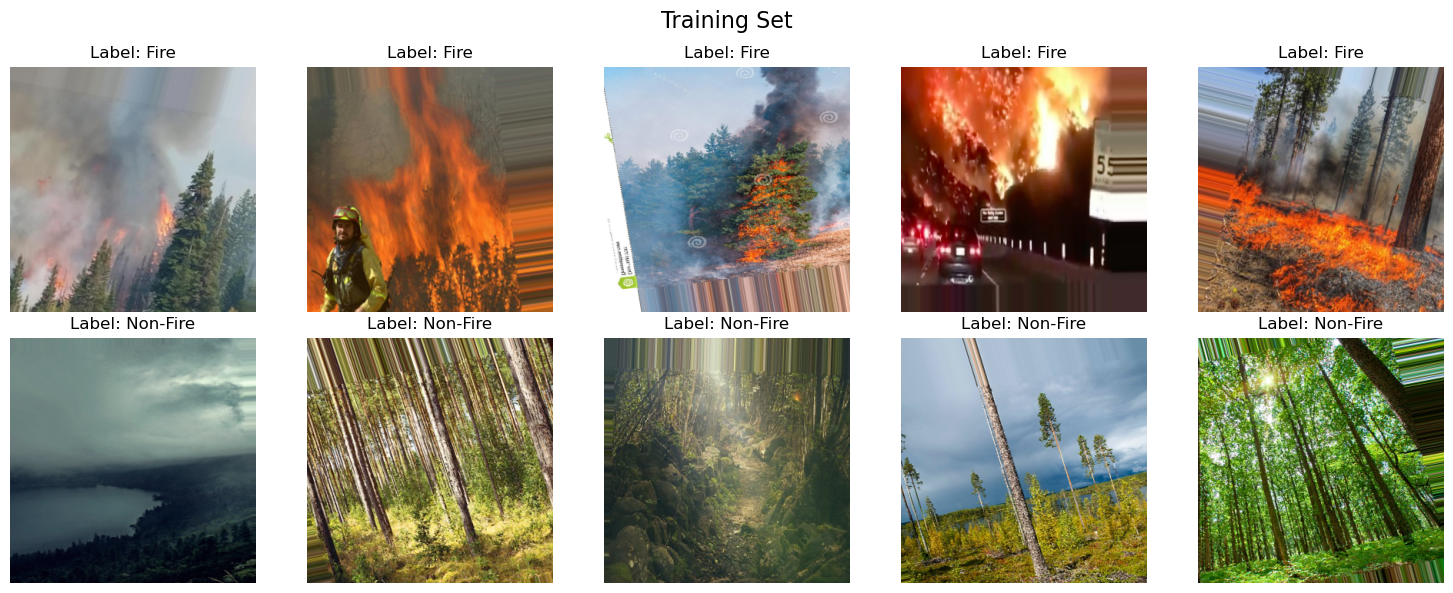

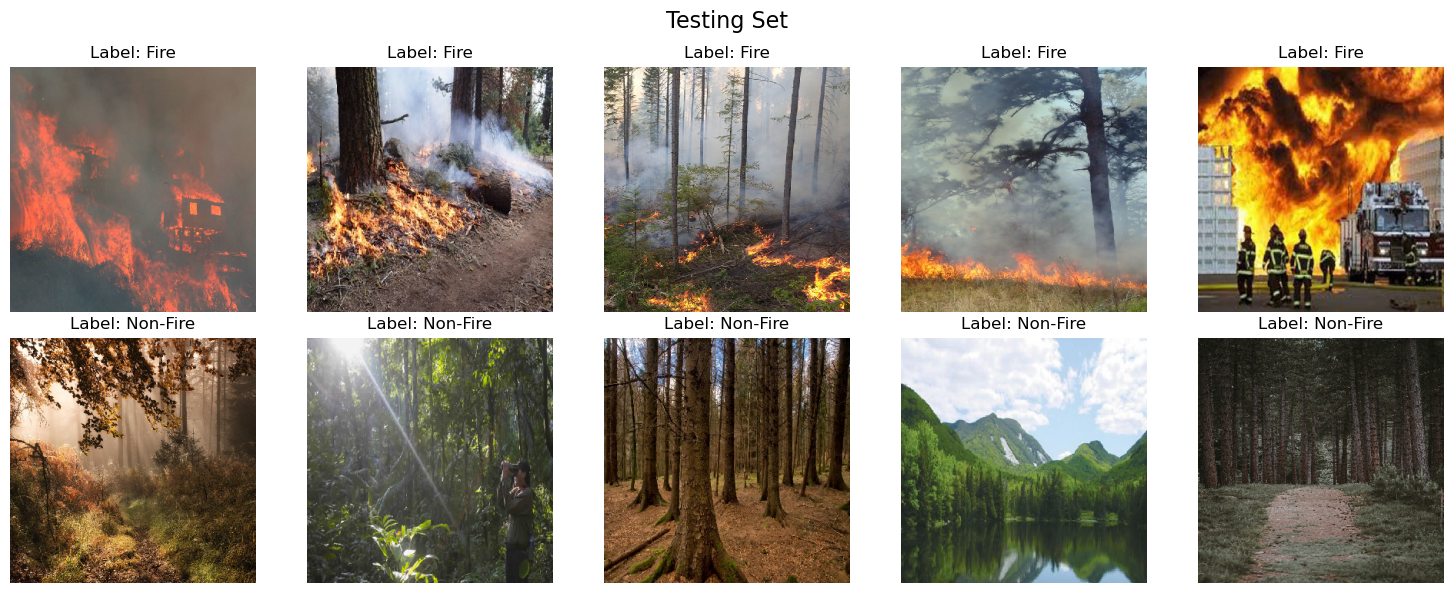

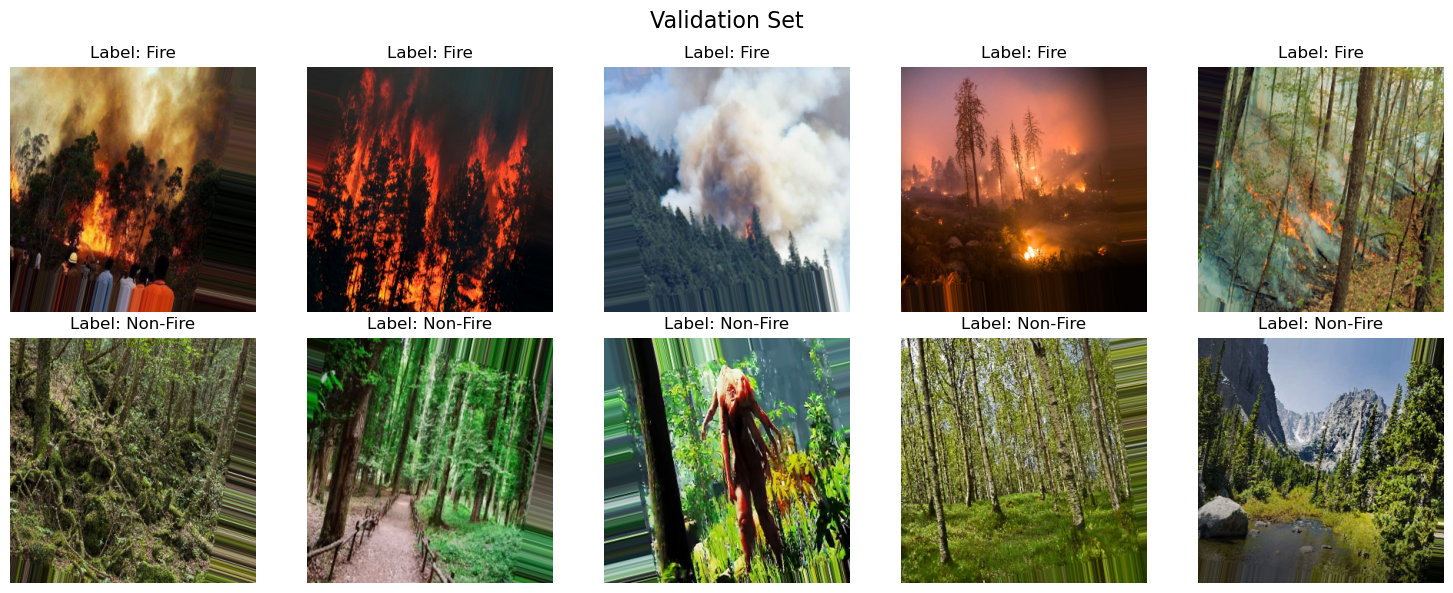

In [77]:
def plot_balanced_images(generator, title, num_per_class=5):
    images_collected = {"fire": [], "nonfire": []}  
    
    while len(images_collected["fire"]) < num_per_class or len(images_collected["nonfire"]) < num_per_class:
        images, labels = next(generator)  
        class_indices = generator.class_indices  
        inv_class_indices = {v: k for k, v in class_indices.items()} 
        class_labels = np.argmax(labels, axis=1)  
        for img, label_idx in zip(images, class_labels):
            class_name = inv_class_indices[label_idx]  
            if class_name in images_collected and len(images_collected[class_name]) < num_per_class:
                images_collected[class_name].append(img)
        if generator.batch_index == 0:
            break  


    selected_images = images_collected["fire"][:num_per_class] + images_collected["nonfire"][:num_per_class]
    labels = ["Fire"] * num_per_class + ["Non-Fire"] * num_per_class
    num_rows = 2 if num_per_class > 1 else 1
    fig, axes = plt.subplots(num_rows, num_per_class, figsize=(15, 6))
    fig.suptitle(title, fontsize=16)
    if num_rows == 1:  
        axes = np.expand_dims(axes, axis=0)

    for i, (img, label) in enumerate(zip(selected_images, labels)):
        ax = axes[i // num_per_class, i % num_per_class]
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f"Label: {label}")

    plt.tight_layout()
    plt.show()

plot_balanced_images(traingen, "Training Set")
plot_balanced_images(testgen, "Testing Set")
plot_balanced_images(valgen, "Validation Set")

In [78]:
#####fire
train_fire_dir_ = os.path.join(output_base_, "train")
train_fire_dir = os.path.join(train_fire_dir_, "fire")
print(train_fire_dir)
val_fire_dir_ = os.path.join(output_base_, "val")
val_fire_dir = os.path.join(val_fire_dir_, "fire")
print(val_fire_dir)
test_fire_dir_ = os.path.join(output_base_, "test")
test_fire_dir = os.path.join(test_fire_dir_, "fire")
print(test_fire_dir)
######non_fire
train_nonfire_dir_ = os.path.join(output_base_, "train")
train_nonfire_dir = os.path.join(train_nonfire_dir_, "nonfire")
print(train_nonfire_dir)
val_nonfire_dir_ = os.path.join(output_base_, "val")
val_nonfire_dir = os.path.join(val_nonfire_dir_, "nonfire")
print(val_nonfire_dir)
test_nonfire_dir_ = os.path.join(output_base_, "test")
test_nonfire_dir = os.path.join(test_nonfire_dir_, "nonfire")
print(test_nonfire_dir)

/home/ladans/Computer Vision/Final Project/Output/train/fire
/home/ladans/Computer Vision/Final Project/Output/val/fire
/home/ladans/Computer Vision/Final Project/Output/test/fire
/home/ladans/Computer Vision/Final Project/Output/train/nonfire
/home/ladans/Computer Vision/Final Project/Output/val/nonfire
/home/ladans/Computer Vision/Final Project/Output/test/nonfire


In [81]:
train_fire = len(os.listdir(train_fire_dir))
val_fire = len(os.listdir(val_fire_dir))
test_fire = len(os.listdir(test_fire_dir))
train_nonfire = len(os.listdir(train_nonfire_dir))
val_nonfire = len(os.listdir(val_nonfire_dir))
test_nonfire = len(os.listdir(test_nonfire_dir))

categories = ["Train", "Validation", "Test"]
fire_counts = [train_fire, val_fire, test_fire]
nonfire_counts = [train_nonfire, val_nonfire, test_nonfire]

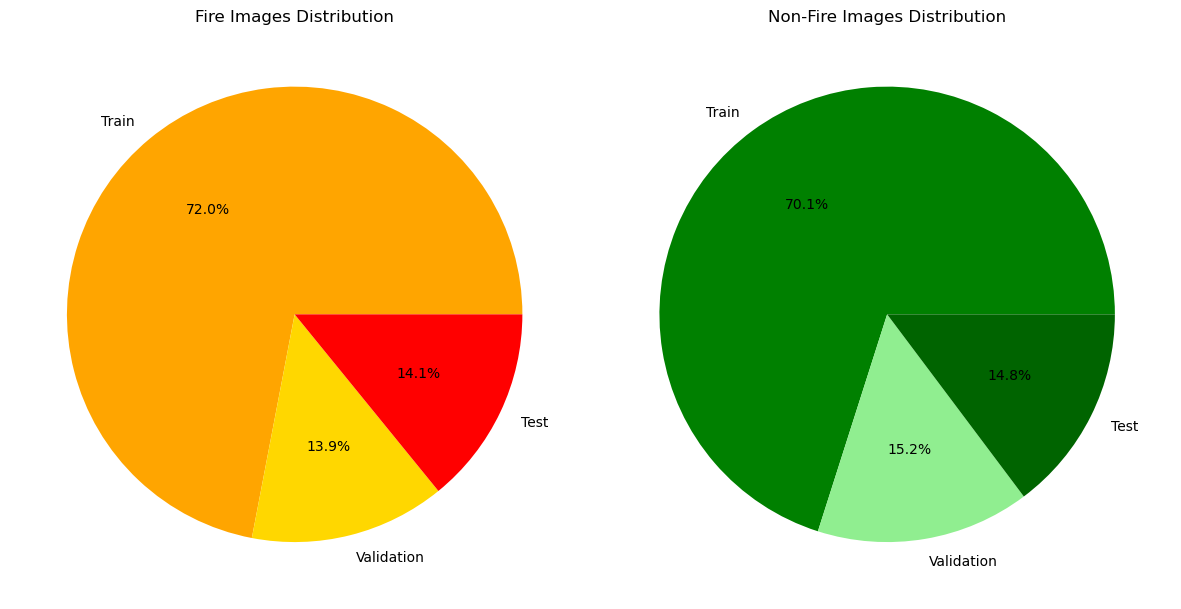

In [82]:
labels = ['Train', 'Validation', 'Test']

fire_counts = [train_fire, val_fire, test_fire]
non_fire_counts = [train_nonfire, val_nonfire, test_nonfire]

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].pie(fire_counts, labels=labels, autopct='%1.1f%%', colors=['orange', 'gold', 'red'])
axes[0].set_title('Fire Images Distribution')

axes[1].pie(non_fire_counts, labels=labels, autopct='%1.1f%%', colors=['green', 'lightgreen', 'darkgreen'])
axes[1].set_title('Non-Fire Images Distribution')

plt.tight_layout()
plt.show()

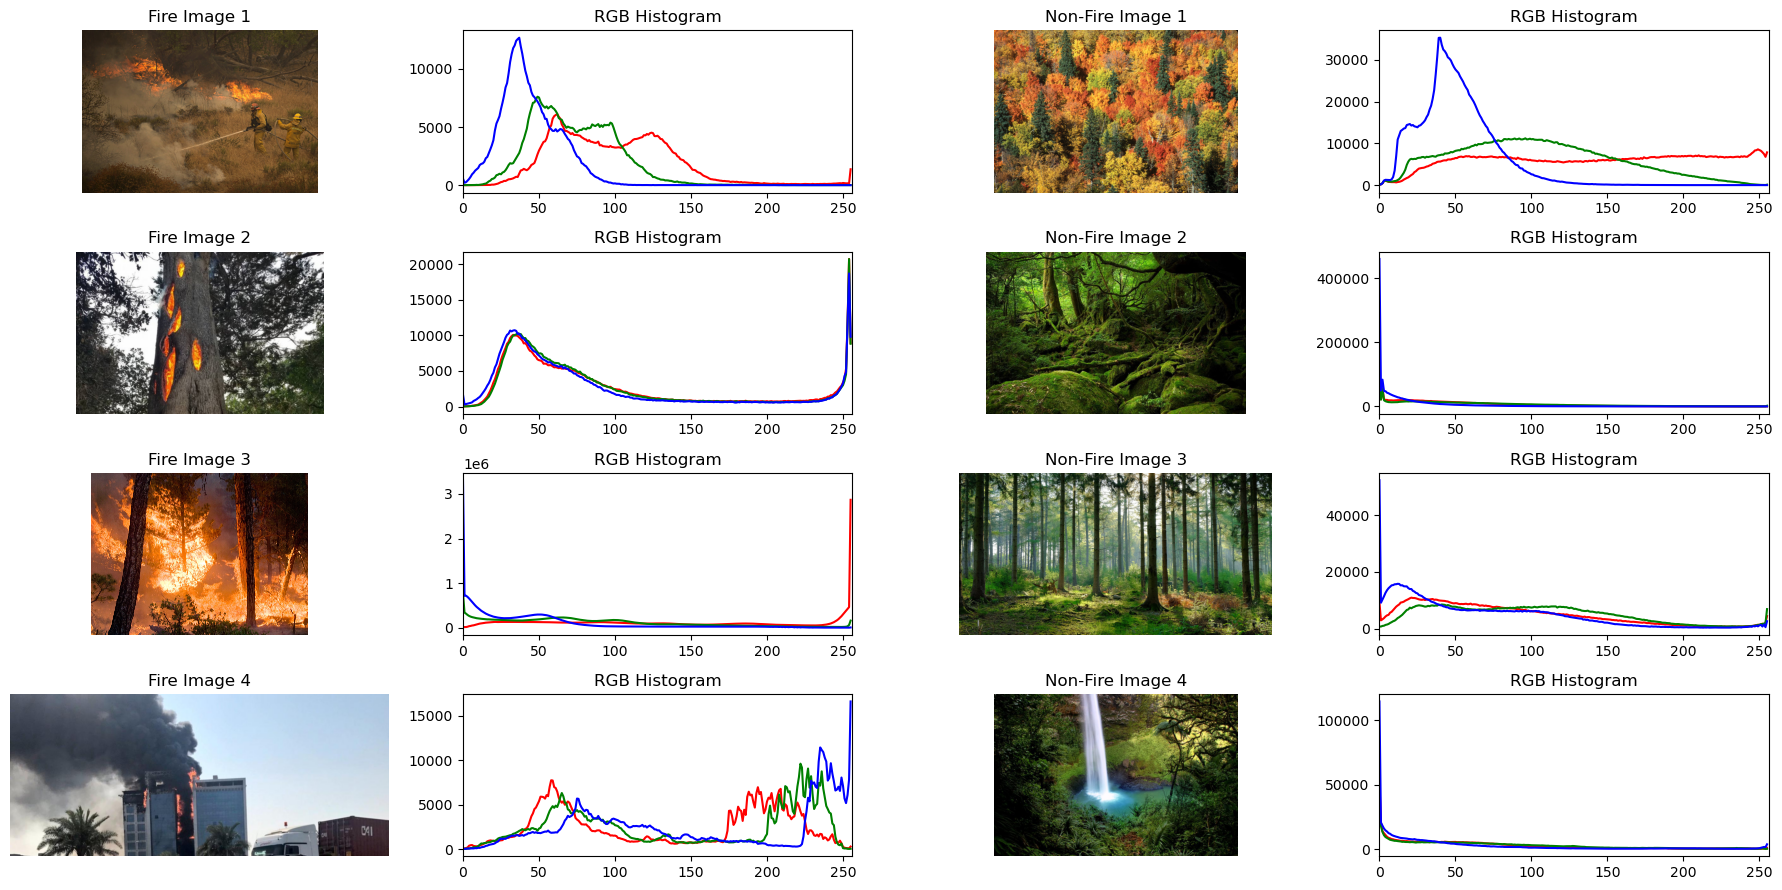

In [14]:
#HISTOGRAM analysis:
import cv2
fire_dir = train_fire_dir  # Fire images
nonfire_dir = train_nonfire_dir  # Non-fire images

# Function to load three random images from a directory
def load_random_images(image_dir, num_images=4):
    image_files = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]
    if len(image_files) < num_images:
        return None  # Return None if not enough images found
    selected_images = random.sample(image_files, num_images)
    images = [cv2.cvtColor(cv2.imread(os.path.join(image_dir, img)), cv2.COLOR_BGR2RGB) for img in selected_images]
    return images

# Load three random fire and non-fire images
fire_images = load_random_images(fire_dir, num_images=4)
nonfire_images = load_random_images(nonfire_dir, num_images=4)

# Check if images were loaded
if fire_images is not None and nonfire_images is not None:
    # Create subplots for fire and non-fire images with histograms
    fig, axes = plt.subplots(4, 4, figsize=(18, 9))

    # Function to plot image and its histogram
    def plot_histogram(image, ax_img, ax_hist, title):
        ax_img.imshow(image)
        ax_img.set_title(title)
        ax_img.axis('off')

        colors = ('r', 'g', 'b')
        for i, color in enumerate(colors):
            hist = cv2.calcHist([image], [i], None, [256], [0, 256])
            ax_hist.plot(hist, color=color)
            ax_hist.set_xlim([0, 256])
        ax_hist.set_title("RGB Histogram")

    # Plot Fire Images and Histograms
    for i in range(4):
        plot_histogram(fire_images[i], axes[i, 0], axes[i, 1], f"Fire Image {i+1}")

    # Plot Non-Fire Images and Histograms
    for i in range(4):
        plot_histogram(nonfire_images[i], axes[i, 2], axes[i, 3], f"Non-Fire Image {i+1}")

    # Adjust layout
    plt.tight_layout()
    plt.show()
else:
    print("Could not load enough images from the specified directories.")


In [15]:
import keras as k
from keras.models import Sequential
from keras.layers import Conv2D,BatchNormalization,Activation,GlobalAveragePooling2D,Dropout,Dense,MaxPooling2D
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam

In [16]:
# Define model
model = Sequential()

# CNN Layer 1
model.add(Conv2D(32, (3,3), padding='same', input_shape=(320, 320, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# CNN Layer 2
model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# CNN Layer 3
model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Global Average Pooling instead of Flatten
model.add(GlobalAveragePooling2D())

# Dense Layer
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Output Layer
model.add(Dense(2, activation='sigmoid'))

# Compile Model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Summary
model.summary()

/opt/conda/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1743605152.172087    1677 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31132 MB memory:  -> device: 0, name: Tesla V100-SXM3-32GB, pci bus id: 0000:5e:00.0, compute capability: 7.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 320, 320, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 320, 320, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 160, 160, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 160, 160, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 160, 160, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 160, 160, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 80, 80, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 80, 80, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 80, 80, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 80, 80, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 40, 40, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 40, 40, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 128,706 (502.76 KB)

 Trainable params: 127,746 (499.01 KB)

 Non-trainable params: 960 (3.75 KB)

In [17]:
#Implementing Early Stopping and Learning Rate Reduction
es=EarlyStopping(monitor='val_loss', patience=25, verbose=1, restore_best_weights=True)
lr=ReduceLROnPlateau(monitor='val_loss', factor=0.001, patience=10, verbose=1, min_delta=0.0001)

callbacks_list=[es,lr]

In [18]:
history = model.fit(
    traingen,
    epochs=5,
    validation_data=valgen,
    callbacks=callbacks_list
)

/opt/conda/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5


I0000 00:00:1743605159.666861    2304 service.cc:152] XLA service 0x7a6220007520 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1743605159.666889    2304 service.cc:160]   StreamExecutor device (0): Tesla V100-SXM3-32GB, Compute Capability 7.0
2025-04-02 14:45:59.742212: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1743605160.194982    2304 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-04-02 14:46:00.958778: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.9 = (f32[32,32,320,320]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,3,320,320]{3,2,1,0} %bitcast.14030, f32[32,3,3,3]{3,2,1,0} %bitcast.14037, f32[32]{0} %bitcast.15216), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target=

 1/24 ━━━━━━━━━━━━━━━━━━━━ 3:26 9s/step - accuracy: 0.5000 - loss: 1.1911

I0000 00:00:1743605165.501159    2304 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


20/24 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - accuracy: 0.7363 - loss: 0.6514

2025-04-02 14:46:58.932281: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.9 = (f32[22,32,320,320]{3,2,1,0}, u8[0]{0}) custom-call(f32[22,3,320,320]{3,2,1,0} %bitcast.14030, f32[32,3,3,3]{3,2,1,0} %bitcast.14037, f32[32]{0} %bitcast.15216), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_1/conv2d_1/convolution" source_file="/opt/conda/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-04-02 14:46:59.018763: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7505 - loss: 0.6237

2025-04-02 14:47:07.277674: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.9 = (f32[32,32,320,320]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,3,320,320]{3,2,1,0} %bitcast.721, f32[32,3,3,3]{3,2,1,0} %bitcast.728, f32[32]{0} %bitcast.730), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_1/conv2d_1/convolution" source_file="/opt/conda/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-04-02 14:47:07.384572: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy

24/24 ━━━━━━━━━━━━━━━━━━━━ 75s 3s/step - accuracy: 0.7535 - loss: 0.6178 - val_accuracy: 0.7533 - val_loss: 0.5919 - learning_rate: 0.0010
Epoch 2/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.9043 - loss: 0.2853 - val_accuracy: 0.7533 - val_loss: 0.5395 - learning_rate: 0.0010
Epoch 3/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.9490 - loss: 0.2056 - val_accuracy: 0.7533 - val_loss: 0.5297 - learning_rate: 0.0010
Epoch 4/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.9116 - loss: 0.3023 - val_accuracy: 0.7533 - val_loss: 0.5596 - learning_rate: 0.0010
Epoch 5/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.9370 - loss: 0.1981 - val_accuracy: 0.7533 - val_loss: 0.5746 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 3.


In [19]:
test_loss, test_accuracy = model.evaluate(testgen)

4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step - accuracy: 0.9824 - loss: 0.2485

2025-04-02 14:49:03.719607: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.9 = (f32[27,32,320,320]{3,2,1,0}, u8[0]{0}) custom-call(f32[27,3,320,320]{3,2,1,0} %bitcast.721, f32[32,3,3,3]{3,2,1,0} %bitcast.728, f32[32]{0} %bitcast.730), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_1/conv2d_1/convolution" source_file="/opt/conda/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-04-02 14:49:03.824609: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 677ms/step - accuracy: 0.9109 - loss: 0.3371


In [20]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tensorflow.keras.utils import to_categorical

Test Accuracy: 0.77
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 468ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.77      1.00      0.87       119
           1       0.00      0.00      0.00        36

    accuracy                           0.77       155
   macro avg       0.38      0.50      0.43       155
weighted avg       0.59      0.77      0.67       155

Confusion Matrix:
[[119   0]
 [ 36   0]] 




/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


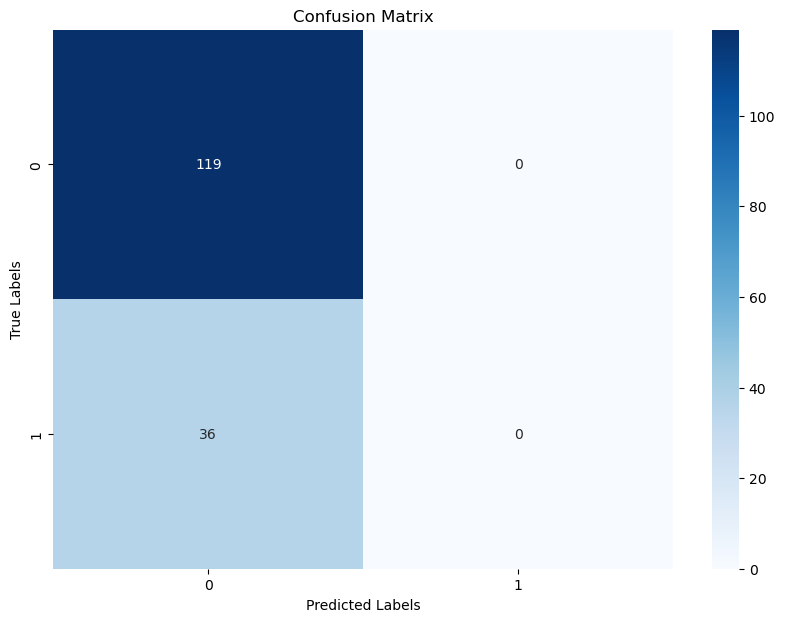

Training class indices: {'fire': 0, 'nonfire': 1}
Test class indices: {'fire': 0, 'nonfire': 1}


In [21]:
print(f"Test Accuracy: {test_accuracy:.2f}")
y_pred = np.argmax(model.predict(testgen), axis=1)
y_true = testgen.classes
print("Classification Report:")
print(classification_report(y_true, y_pred))
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix,'\n\n')
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', )
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
print("Training class indices:", traingen.class_indices)
print("Test class indices:", testgen.class_indices)

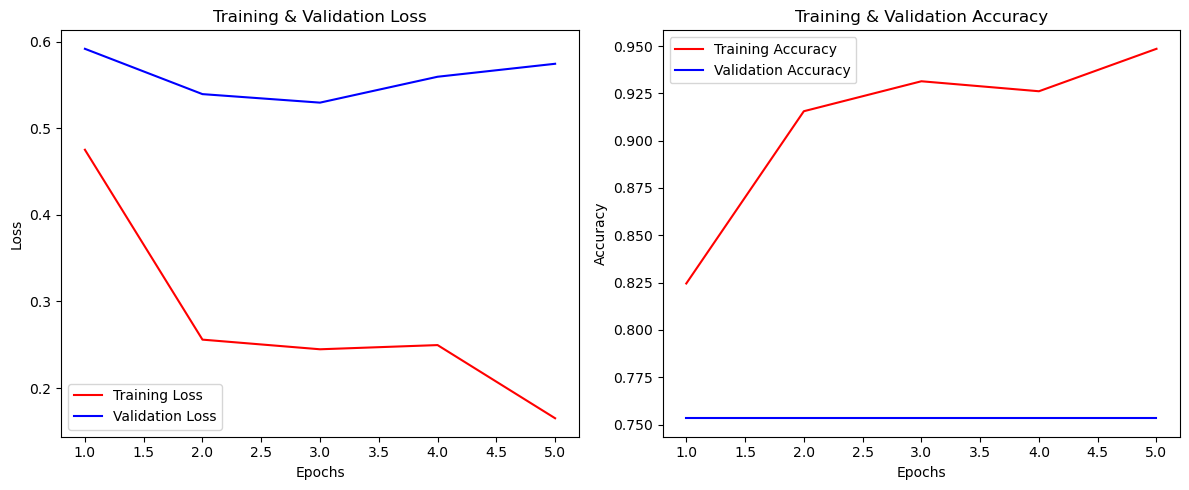

In [22]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)


plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [23]:
#save the outputs of the Network to detect fire
# Get class indices mapping
class_indices = traingen.class_indices  # {'fire': 0, 'non-fire': 1}
print("Class Indices:", class_indices)


Class Indices: {'fire': 0, 'nonfire': 1}


In [24]:
#Canny

In [51]:
import os
current_directory = os.getcwd()
print(current_directory)
dir_save = os.path.join(current_directory,'fired_images_classified')
print(dir_save)
test_dir = os.path.join(output_base_, "test")
print(test_dir)

/home/ladans/Computer Vision/Final Project
/home/ladans/Computer Vision/Final Project/fired_images_classified
/home/ladans/Computer Vision/Final Project/Output/test


In [52]:
#!pip install --upgrade pillow
!pip install opencv-python

Fire Image Directory: /home/ladans/Computer Vision/Final Project/Output/test/fire
115


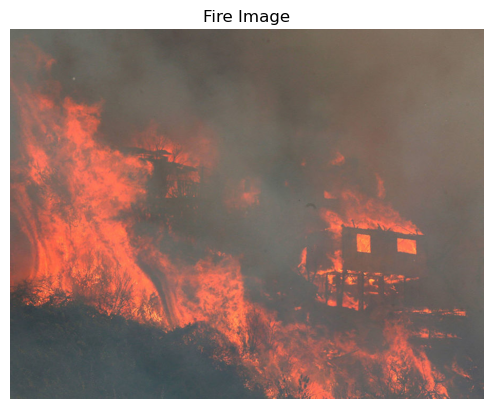

In [53]:
import cv2
import os
import matplotlib.pyplot as plt
from PIL import Image

im_path_ = os.path.join(output_base_, "test")
im_path = os.path.join(im_path_, "fire")
print("Fire Image Directory:", im_path)

image_files = [f for f in os.listdir(im_path)]
print(len(image_files))

image_path = os.path.join(im_path, image_files[50])
img = Image.open(image_path).convert('RGB')
plt.imshow(img)
plt.axis('off')
plt.title("Fire Image")
plt.show()


In [54]:
###################################Detection Part###############################

In [55]:
#RGB to HSV
def rgb2hsv(RGB):
    '''
    Performs RGB to HSV conversion on the input Image object RGB and
    returns HSV representation as a numpy array.
    Uses "A. R. Smith, “Color gamut transform pairs,” 
    ACM SIGGRAPH Computer Graphics, vol. 12, no. 3. Association for Computing Machinery (ACM), 
    pp. 12-19, Aug. 23, 1978. doi: 10.1145/965139.807361."
    '''
    RGB = np.array(RGB).astype(float) / 255.0
    HSV = np.zeros(RGB.shape)
    for y in range(RGB.shape[0]):
        for x in range(RGB.shape[1]):
            R, G, B = RGB[y,x,:]
            V = np.max((R, G, B))
            m = np.min((R, G, B))
            C = V - m
            if V == 0.0:
                S = 0.0
            else:
                S = C / V
                
            if C == 0.0:
                H = 0.0
            else:
                if V == R:
                    H_prime = (G-B) / C
                elif V == G:
                    H_prime = (B-R) / C + 2
                elif V == B:
                    H_prime = (R-G) / V + 4
                
                if H_prime < 0:
                    H = H_prime / 6 + 1
                else:
                    H = H_prime / 6
            
            HSV[y,x,0] = H
            HSV[y,x,1] = S
            HSV[y,x,2] = V
    
    return HSV

In [56]:
hsv = rgb2hsv(img)

In [57]:
hsv.shape

(701, 898, 3)

In [58]:
H = Image.fromarray((hsv[:,:,0] * 255).astype(np.uint8))
S = Image.fromarray((hsv[:,:,1] * 255).astype(np.uint8))
V = Image.fromarray((hsv[:,:,2] * 255).astype(np.uint8))

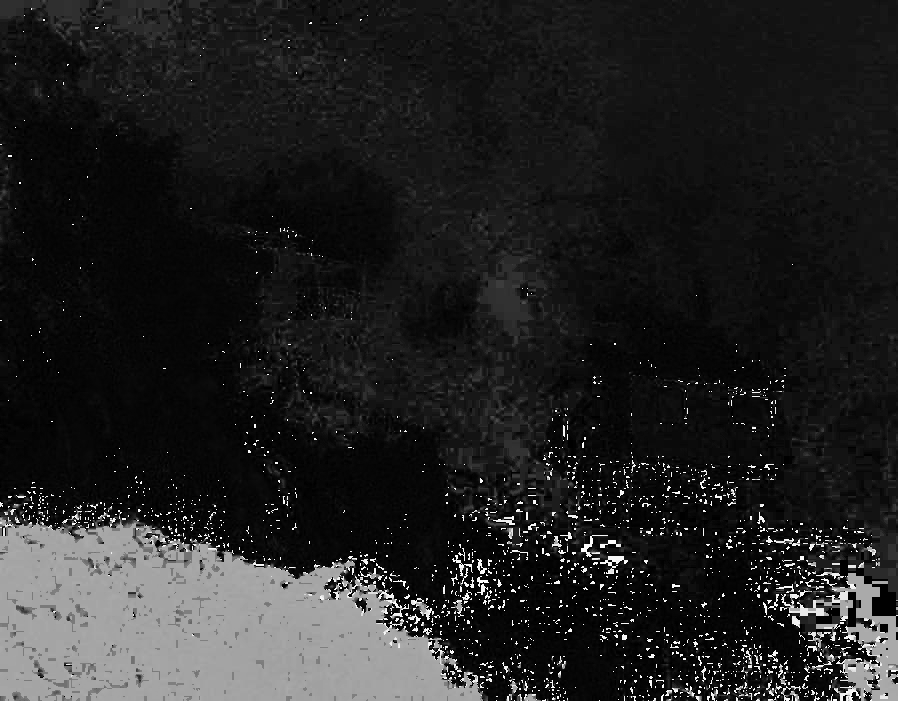

In [59]:
display(H)

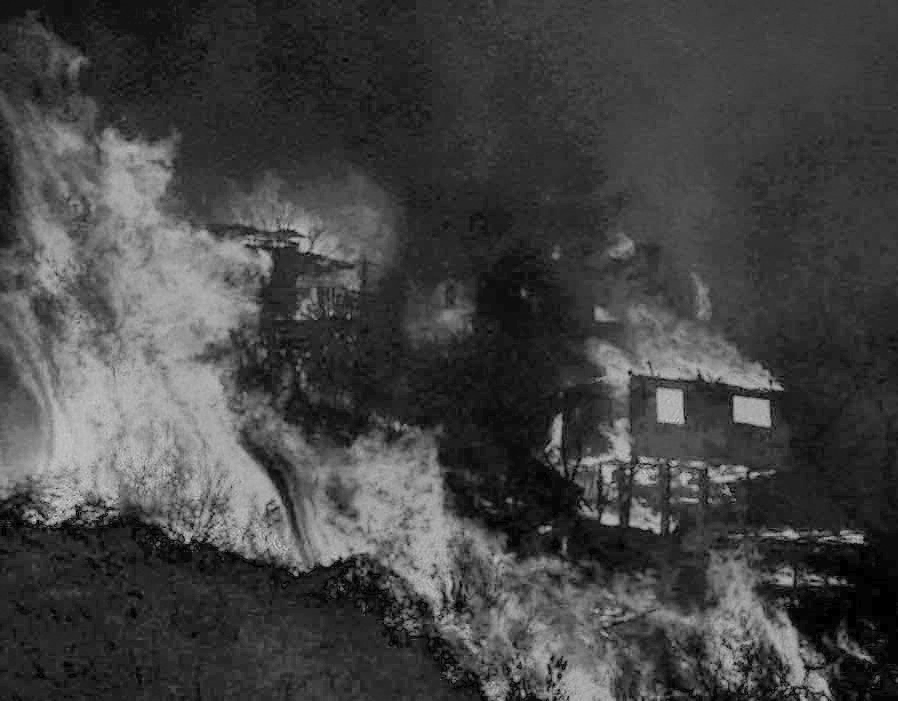

In [60]:
display(S)

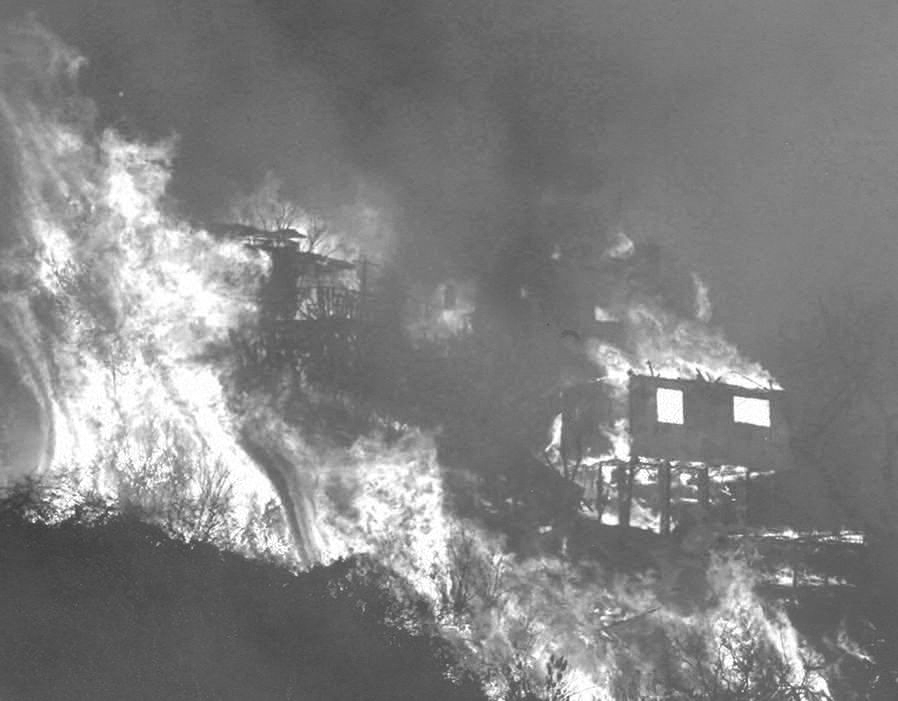

In [61]:
display(V)

In [62]:
#Detection

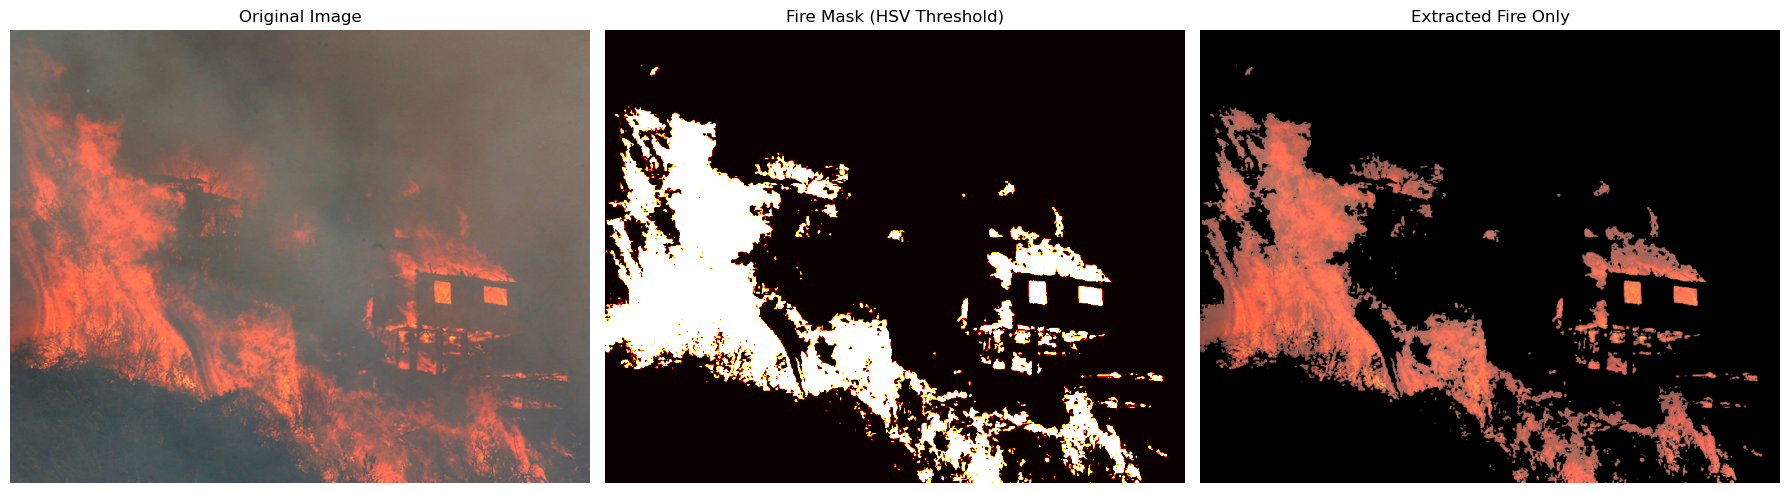

In [74]:
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt

def detect_fire_pil(image_path):
    image_np = rgb2hsv(img)

    h = image_np[:, :, 0]
    s = image_np[:, :, 1]
    v = image_np[:, :, 2]
    
    fire_mask = (
        (h >= 0.0) & (h <= 0.15) &  # Hue range for fire
        (s >= 0.4) & (v >= 0.4)     # Saturation and brightness
    ).astype(np.uint8)

    # Mask fire regions
    fire_mask_np = fire_mask.astype(np.uint8)

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    axes[0].imshow(img)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    axes[1].imshow(fire_mask_np, cmap="hot")
    axes[1].set_title("Fire Mask (HSV Threshold)")
    axes[1].axis("off")
    mask_image = Image.fromarray(fire_mask_np * 255).convert("L")
    mask_image.save("fire_mask_output.png")

    # Convert original image to NumPy array
    img_np_ = np.array(img)
    
    # Expand fire mask to 3 channels to match image shape
    fire_mask_3c = np.stack([fire_mask_np]*3, axis=-1)
    
    # Apply the mask: keep fire regions, set others to black
    fire_only = img_np_ * fire_mask_3c
    
    fire_only_image = Image.fromarray(fire_only.astype(np.uint8))
    fire_only_image.save("fire_only_extracted.png")
    axes[2].imshow(fire_only_image)
    axes[2].set_title("Extracted Fire Only")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()  
detect_fire_pil(img)

In [65]:
def apply_canny_on_fire_region(fire_region_np, show_plot=True, save_path=None):
    fire_gray = cv2.cvtColor(fire_region_np.astype(np.uint8), cv2.COLOR_RGB2GRAY)
    fire_blur = cv2.GaussianBlur(fire_gray, (5, 5), 0)
    edges = cv2.Canny(fire_blur, threshold1=100, threshold2=200)

    if show_plot:
        plt.figure(figsize=(6, 6))
        plt.imshow(edges, cmap='gray')
        plt.title("Canny Edge Detection on Fire Region")
        plt.axis("off")
        plt.show()

    if save_path:
        edge_image = Image.fromarray(edges)
        edge_image.save(save_path)

    return edges

In [66]:
current_directory = os.getcwd()
print(current_directory)
im_path_canny = os.path.join(current_directory, "fire_only_extracted.png")
print("Fire Image Directory:", im_path_canny)
img_canny = Image.open(im_path_canny).convert('RGB')

/home/ladans/Computer Vision/Final Project
Fire Image Directory: /home/ladans/Computer Vision/Final Project/fire_only_extracted.png


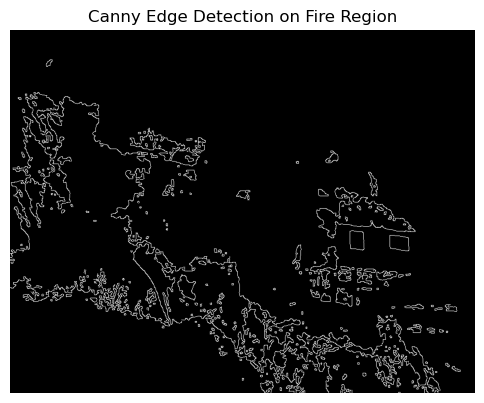

In [67]:
img_canny_np = np.array(img_canny) 
edges=apply_canny_on_fire_region(img_canny_np)

In [68]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def draw_bounding_boxes_on_edges(fire_region_np, edges, min_area=100):
    """
    Draws bounding boxes around edge-detected regions on fire_region_np.
    
    fire_region_np: original fire-only image (NumPy array)
    edges: binary image from Canny (NumPy array)
    min_area: minimum area to draw a box
    """
    fire_with_boxes = fire_region_np.copy()
    
    # Find contours from edge map
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        area = w * h
        if area > min_area:
            cv2.rectangle(fire_with_boxes, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Green box
    
    plt.figure(figsize=(8, 6))
    plt.imshow(fire_with_boxes)
    plt.title("Fire Region with Bounding Boxes")
    plt.axis("off")
    plt.show()

    return fire_with_boxes


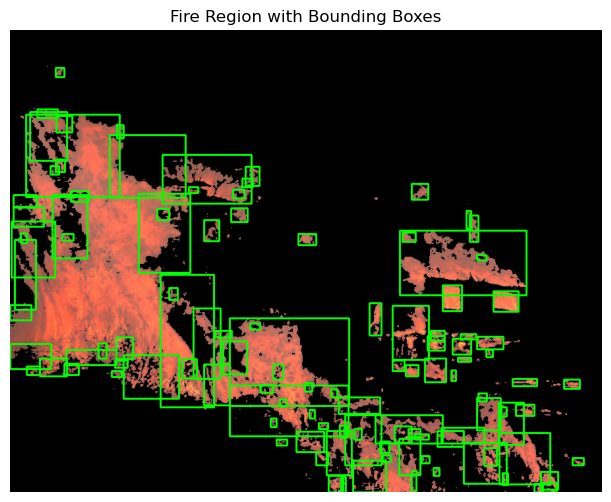

In [69]:
fire_with_boxes=draw_bounding_boxes_on_edges(img_canny_np,edges)